Imports

In [10]:
import tensorflow as tf
import numpy as np
import os # To interact with operating system, to read and open files
import cv2 # Library for image processing, to read and resize images
import pickle
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.18.0
NumPy version: 1.26.0


### Loading dataset

The data was acquired from https://github.com/garythung/trashnet

In [13]:
# Path to the dataset
dataset_path = "/Users/amandadotkom/Projects/TrashSelection/dataset-resized"

# Load images and labels
# The images in the data are already resized by the authors to the dimension 512x384
# Function returns an array of images (array of normalized pixel values), array of numeric labels for each category, and numeric-to-cateogry label mapping
def load_dataset(dataset_path, image_size=(512, 384)):
    images = [] # A list to store image data as arrays
    labels = [] # Stores the corresponding numeric label for each category (0:paper, 1:metal...)
    
    # Only include directories (categories). This was done to avoid including .DS_Store which is created by Mac
    categories = [
        category for category in os.listdir(dataset_path) 
        if os.path.isdir(os.path.join(dataset_path, category))
    ]
    
    # Create a label map and assign a unique label to each category
    label_map = {idx: category for idx, category in enumerate(categories)}

    for label, category in label_map.items():
        category_path = os.path.join(dataset_path, category)

        for img_file in os.listdir(category_path): # For each image in the category folder
            img_path = os.path.join(category_path, img_file) # Path for current image
            img = cv2.imread(img_path) # Reads the current image as an array of pixel values
            # img = cv2.resize(img, image_size)  # Resize if needed
            images.append(img / 255.0)  # Normalize pixel values to 0-1.0. Pixel values (in std 8-bit image) range from 0-255 
            labels.append(label) # Adds the numeric label of the category to labels list

    return np.array(images), np.array(labels), label_map

images, labels, label_map = load_dataset(dataset_path)

print(f"Number of categories: {len(label_map)}")
print(f"Categories: {list(label_map.values())}")
print(f"Unique labels: {np.unique(labels)}")
print(f"Number of images: {len(images)}")


Number of categories: 6
Categories: ['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']
Unique labels: [0 1 2 3 4 5]
Number of images: 2527


Save the processed dataset

In [14]:
# Save everything in one file
with open("processed_dataset.pkl", "wb") as f:
    pickle.dump((images, labels, label_map), f)

print("Dataset saved in a single file!")


Dataset saved in a single file!


### Split data

Load pickle file with previously saved processed dataset

In [15]:
# Load everything from the single file
# images contain each image as an array of (normalized) pixel values
# labels contain the numerical label of the category
# label_map is a dictionary linking numerical label to correspoding category
with open("processed_dataset.pkl", "rb") as f:
    images, labels, label_map = pickle.load(f)

print(f"Loaded {len(images)} images.")
print(f"Label map: {label_map}")


Loaded 2527 images.
Label map: {0: 'paper', 1: 'metal', 2: 'cardboard', 3: 'trash', 4: 'glass', 5: 'plastic'}


In [20]:
from sklearn.model_selection import train_test_split

# Split the dataset 80 train, 20 test
# Training 
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Validation
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(test_images)} images")


Training set: 2021 images
Validation set: 253 images
Test set: 253 images


Visualize dataset

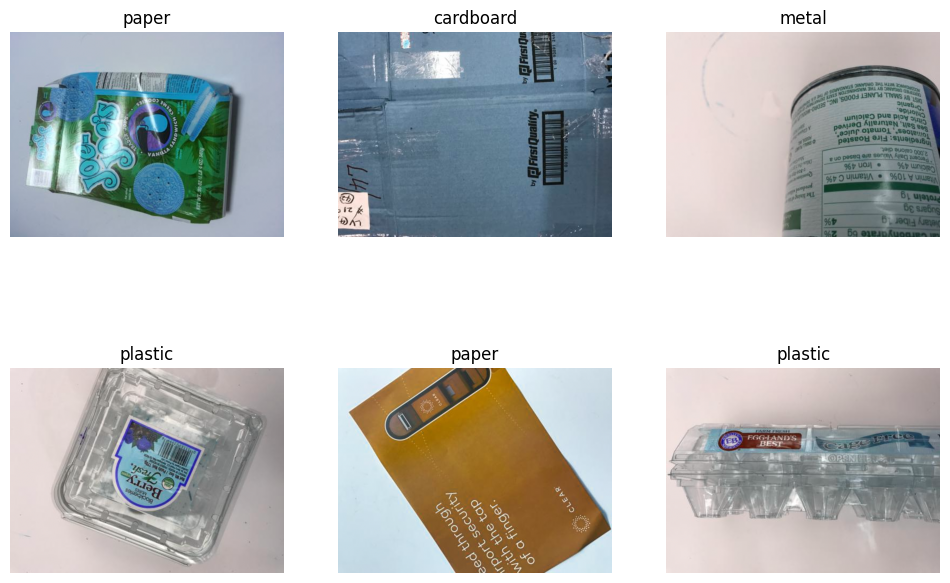

In [22]:
import matplotlib.pyplot as plt

# Visualize some images with their labels
def visualize_images(images, labels, label_map, num_images=6):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 3, i+1) # rows, cols, idx
        plt.imshow(images[i])
        plt.title(label_map[labels[i]])
        plt.axis('off')
    plt.show()

visualize_images(train_images, train_labels, label_map)


### Data preprocessing

Check the shape of the dataset

TensorFlow requires the parameters (batch_size, height, width, channels). The batch size is -1, which allows for the program to determine the batch size at runtime depending on the input data (allows flexibility; no hard coding batch_size, and the same model can be used for different batch sizes during training and inference). For RGB images, the number of channels is 3 (i.e, red green blue).

In [23]:
print(f"Training data shape: {train_images.shape}")
print(f"Validation data shape: {val_images.shape}")
print(f"Test data shape: {test_images.shape}")

Training data shape: (2021, 384, 512, 3)
Validation data shape: (253, 384, 512, 3)
Test data shape: (253, 384, 512, 3)


One-hot encoding

For a classification problem, the numeric labels have to be converted into one-hot encoded vectors.

In [24]:

from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
num_classes = len(label_map)  # Number of categories
train_labels = to_categorical(train_labels, num_classes)
val_labels = to_categorical(val_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

print(f"Example one-hot encoded label: {train_labels[0]}")


Example one-hot encoded label: [1. 0. 0. 0. 0. 0.]


Data augmentation  

Useful to make the model more robust by applying random transformations to the image data. The images are augmented by rotations, zooms, flips, etc. Good for generalization and avoids overfitting.

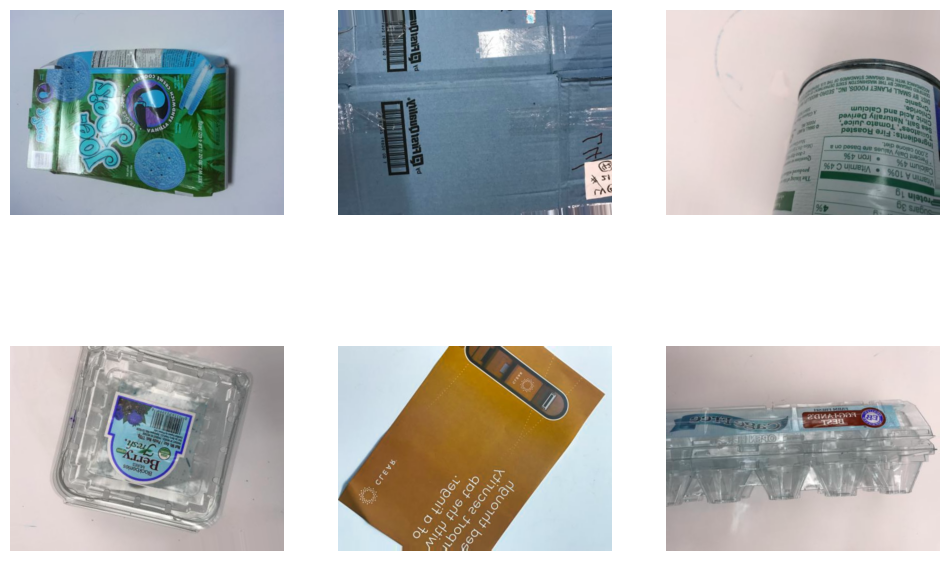

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation pipeline
datagen = ImageDataGenerator(
    rotation_range=10,         # Random rotation by +- 10 degrees

    # shifts are not included because some of the images contain objects that are already off-center
    # width_shift_range=0.2,     # Horizontal shift, simulates the object being off-center
    # height_shift_range=0.2,    # Vertical shift, same reason for width shift
    
    # zoom_range=0.2,            # Random zoom, teaches the model to handle objects with different scale
    
    horizontal_flip=True,      # Random horizontal flip, teached the model to recognize an object with different orientations
    fill_mode='nearest'        # Fill missing pixels after a shift/rotation with nearby pixel values
)

# Fit the generator to the training data
datagen.fit(train_images)

# Example: Visualize augmented images
for batch in datagen.flow(train_images[:6], batch_size=6, shuffle=False):
    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(batch[i])
        plt.axis('off')
    plt.show()
    break
